<a href="https://colab.research.google.com/github/sid-chaubs/data-mining-assignment-1/blob/main/DMT_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Loading and formatting data

In [73]:
from google.colab import drive
drive.mount('/content/datadrive')

Drive already mounted at /content/datadrive; to attempt to forcibly remount, call drive.mount("/content/datadrive", force_remount=True).


In [74]:
!mkdir /content/training_data
!mkdir /content/test_data
!unzip -o /content/datadrive/MyDrive/training_set_VU_DM.csv.zip -d /content/training_data/
!unzip -o /content/datadrive/MyDrive/test_set_VU_DM.csv.zip -d /content/test_data/
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann
!pip install -q surprise

mkdir: cannot create directory ‘/content/training_data’: File exists
mkdir: cannot create directory ‘/content/test_data’: File exists
Archive:  /content/datadrive/MyDrive/training_set_VU_DM.csv.zip
  inflating: /content/training_data/training_set_VU_DM.csv  
Archive:  /content/datadrive/MyDrive/test_set_VU_DM.csv.zip
  inflating: /content/test_data/test_set_VU_DM.csv  


In [75]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick import target, features
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import surprise

SEED = 1337 * 420 * 69
SAMPLE_SIZE = 5000

np.random.seed(SEED)

|Column Name|Data Type|Description|
|-----------|---------|-----------|
|srch_id|Integer|The ID of the search|
|date_time|Date/time|Date and time of the search|
|site_id|Integer|ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, ..)|
|visitor_location_country_id |Integer|The ID of the country the customer is located|
|visitor_hist_starrating |Float|The mean star rating of hotels the customer has previously purchased; null signifies there is no purchase history on the customer|
|visitor_hist_adr_usd|Float|The mean price per night (in US$) of the hotels the customer has previously purchased; null signifies there is no purchase history on the customer|
|prop_country_id|Integer|The ID of the country the hotel is located in|
|prop_id|Integer|The ID of the hotel|
|prop_starrating|Integer|The star rating of the hotel, from 1 to 5, in increments of 1.  A 0 indicates the property has no stars, the star rating is not known or cannot be publicized.|
|prop_review_score|Float|The mean customer review score for the hotel on a scale out of 5, rounded to 0.5 increments. A 0 means there have been no reviews, null that the information is not available.|
|prop_brand_bool|Integer|+1 if the hotel is part of a major hotel chain; 0 if it is an independent hotel|
|prop_location_score1|Float|A (first) score outlining the desirability of a hotel’s location|
|prop_location_score2|Float|A (second) score outlining the desirability of the hotel’s location|
|prop_log_historical_price position|Float   Integer|The logarithm of the mean price of the hotel over the last trading period. A 0 will occur if the hotel was not sold in that period. Hotel position on Expedia's search results page. This is only provided for the training data, but not the test data.|
|price_usd|Float|Displayed price of the hotel for the given search.  Note that different countries have different conventions regarding displaying taxes and fees and the value may be per night or for the whole stay|
|promotion_flag|Integer|+1 if the hotel had a sale price promotion specifically displayed|
|gross_booking_usd     srch_destination_id |Float     Integer|Total value of the transaction.  This can differ from the price_usd due to taxes, fees, conventions on multiple day bookings and purchase of a room type other than the one shown in the search ID of the destination where the hotel search was performed|
|srch_length_of_stay|Integer|Number of nights stay that was searched|
|srch_booking_window|Integer|Number of days in the future the hotel stay started from the search date|
|srch_adults_count|Integer|The number of adults specified in the hotel room|
|srch_children_count|Integer|The number of (extra occupancy) children specified in the hotel room|
|srch_room_count|Integer|Number of hotel rooms specified in the search|
|srch_saturday_night_bool|Boolean|+1 if the stay includes a Saturday night, starts from Thursday with a length of stay is less than or equal to 4 nights (i.e. weekend); otherwise 0|
|srch_query_affinity_score|Float|The log of the probability a hotel will be clicked on in Internet searches (hence the values are negative)  A null signifies there are no data (i.e. hotel did not register in any searches)|
|orig_destination_distance|Float|Physical distance between the hotel and the customer at the time of search. A null means the distance could not be calculated.|
|random_bool|Boolean|+1 when the displayed sort was random, 0 when the normal sort order was displayed|
| | | |
|comp1_rate|Integer|+1 if Expedia has a lower price than competitor 1 for the hotel; 0 if the same; -1 if Expedia’s price is higher than competitor 1; null signifies there is no competitive data|
|comp1_inv |Integer|+1 if competitor 1 does not have availability in the hotel; 0 if both Expedia and competitor 1 have availability; null signifies there is no competitive data|
|comp1_rate_percent_diff|Float|The absolute percentage difference (if one exists) between Expedia and competitor 1’s price (Expedia’s price the denominator); null signifies there is no competitive data|
|comp2_rate| | |
|comp2_inv| |(same, for competitor 2 through 8)|


In [4]:
train_data = pd.read_csv('/content/training_data/training_set_VU_DM.csv')
test_data = pd.read_csv('/content/test_data/test_set_VU_DM.csv')

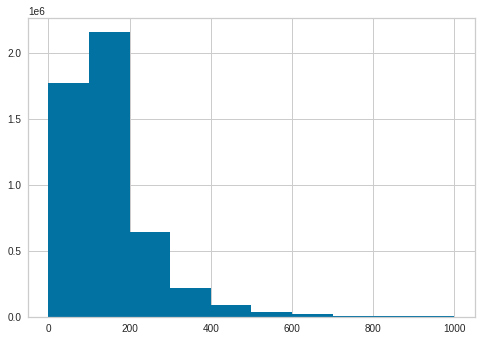

In [5]:
train_data[train_data['price_usd'] < 1000]['price_usd'].hist()

In [6]:
nan_filter = np.sum(train_data.isna()) > 0.75 * train_data.shape[0]
print('Dropping {0} columns: {1}'.format(len(train_data.columns[nan_filter]), train_data.columns[nan_filter]))
train_data = train_data.drop(columns=train_data.columns[nan_filter])
train_data.drop(columns=['date_time'], inplace=True)
test_data.drop(columns=['date_time'], inplace=True) #not using date time to predict anything, since it's unlikely to be relevant
train_data.drop(columns=['position'], inplace=True) #this does not appear in test data, so won't be a useful predictor
data_sample = train_data.sample(SAMPLE_SIZE, random_state=SEED)

Dropping 20 columns: Index(['visitor_hist_starrating', 'visitor_hist_adr_usd',
       'srch_query_affinity_score', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate_percent_diff',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate_percent_diff', 'comp6_rate',
       'comp6_inv', 'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'comp7_rate_percent_diff', 'comp8_rate_percent_diff',
       'gross_bookings_usd'],
      dtype='object')


In [7]:
#massaging input for pre-visualization before model selection
sample_numeric = data_sample.select_dtypes('number')
sample_X = pd.DataFrame.copy(sample_numeric, deep=True)
sample_y_booking = sample_X.pop('booking_bool')
sample_y_click = sample_X.pop('click_bool')


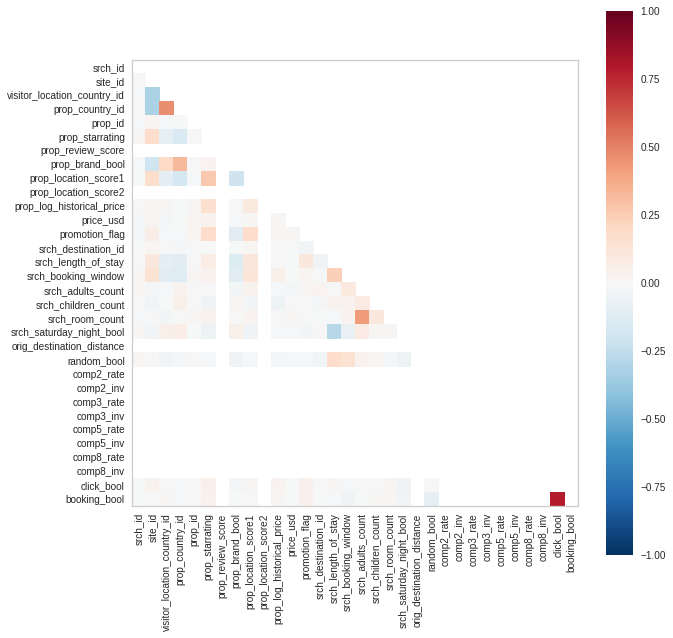

In [8]:
vis2d = features.Rank2D(algorithm='pearson', features=data_sample.select_dtypes('number').columns)
plt.figure(figsize=(10,10))
vis2d.fit_transform(np.matrix(data_sample.select_dtypes('number')));


We see that clicking has a very high positive correlation with booking. Other notabe positive correlations are between the search count of adults and the search room count, as well as visitor's country and property's country.

In [9]:
train_data[train_data.booking_bool == True][['prop_country_id','visitor_location_country_id', 'srch_destination_id']].corr()

,prop_country_id,visitor_location_country_id,srch_destination_id
prop_country_id,1.000000,0.498800,-0.007498
visitor_location_country_id,0.498800,1.000000,0.000208
srch_destination_id,-0.007498,0.000208,1.000000


We see that the search destination IDs are hardly correlated at all with either property country IDs or visitor location country IDs. However, the property country IDs and visitor location country IDs show a really strong correlation, which might aid in filtering results.

Text(0.5, 1.0, 'Shapiro-Wilk normality rank')

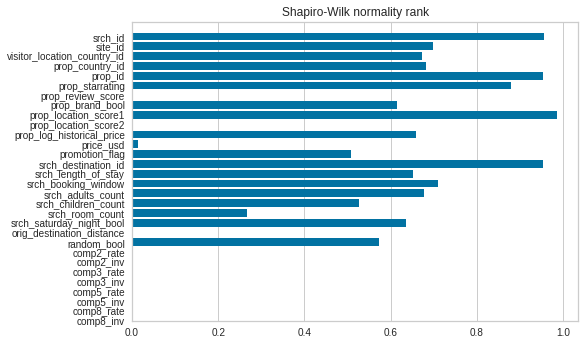

In [10]:
vis1d = features.rank1d(np.array(sample_X), features=sample_X.columns)
plt.title('Shapiro-Wilk normality rank')

We can see some features are very normally distributed, while others (review score, price) almost not at all.

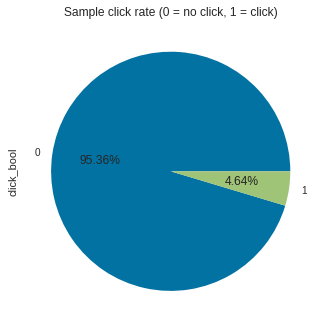

In [11]:
sample_y_click.value_counts().plot.pie(autopct='%1.2f%%');
plt.title('Sample click rate (0 = no click, 1 = click)');

Only 4 percent of searches result in a click-through.

0.2248468986642564 4.558650521938678 0.14610607248759921


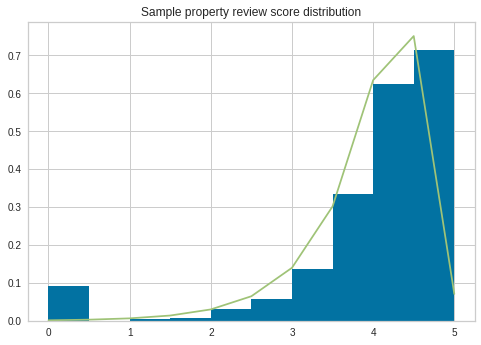

In [12]:
_, rscorebins, _ = plt.hist(np.abs(sample_X.prop_review_score), density=1);
plt.title('Sample property review score distribution');

rs_params = sp.stats.genlogistic.fit(sample_X[sample_X.prop_review_score > 0].prop_review_score) #(5, 0.6)
print(*rs_params)
norm_fit_line = sp.stats.genlogistic.pdf(rscorebins, *rs_params)

plt.plot(rscorebins, norm_fit_line)

Text(0.5, 1.0, 'Sample prices distribution above 2000 USD')

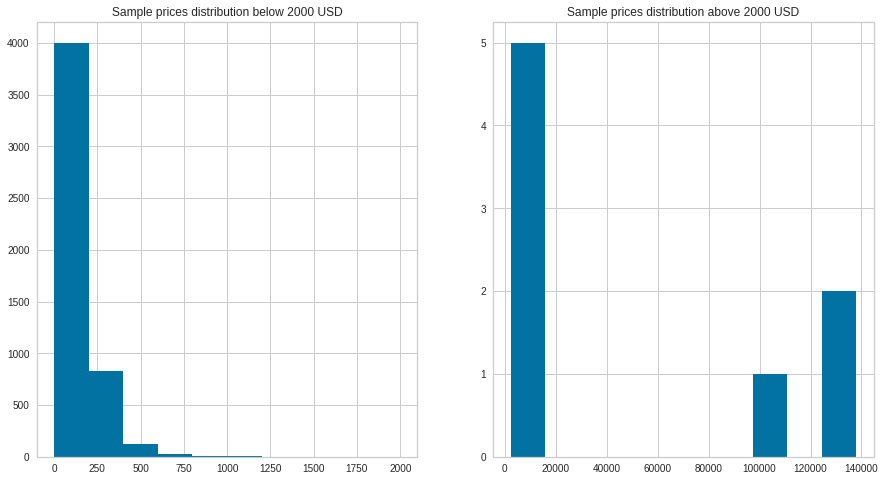

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 8))
ax[0].hist(sample_X[sample_X.price_usd < 2000].price_usd)
ax[0].set_title('Sample prices distribution below 2000 USD');
ax[1].hist(sample_X[sample_X.price_usd > 2000].price_usd)
ax[1].set_title('Sample prices distribution above 2000 USD')

Text(0.5, 1.0, 'Sample comparison with rates of competitor 2 (-1 = competitor has better price, 0 = no data, 1 = Expedia has better price)')

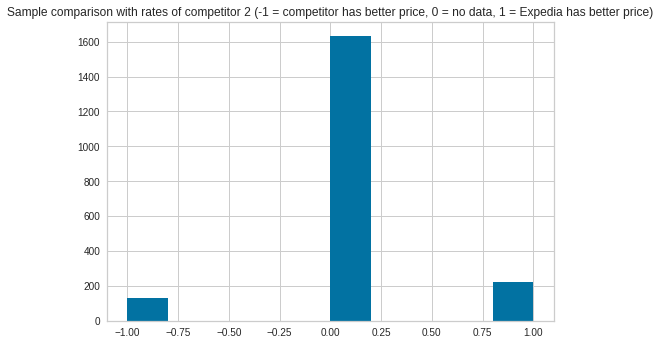

In [14]:
plt.hist(sample_X.comp2_rate)
plt.title('Sample comparison with rates of competitor 2 (-1 = competitor has better price, 0 = no data, 1 = Expedia has better price)')

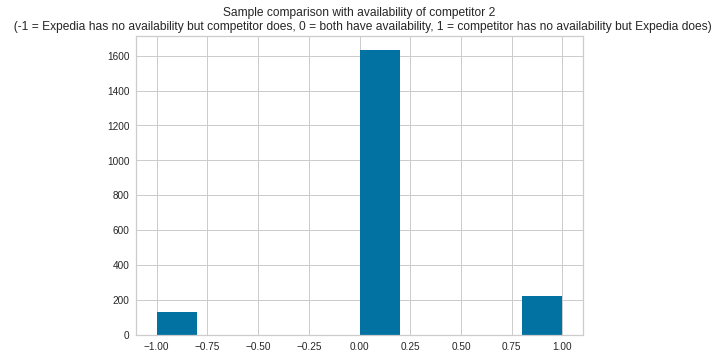

In [15]:
plt.hist(sample_X.comp2_rate)
plt.title('''Sample comparison with availability of competitor 2
  (-1 = Expedia has no availability but competitor does, 0 = both have availability, 1 = competitor has no availability but Expedia does)''');

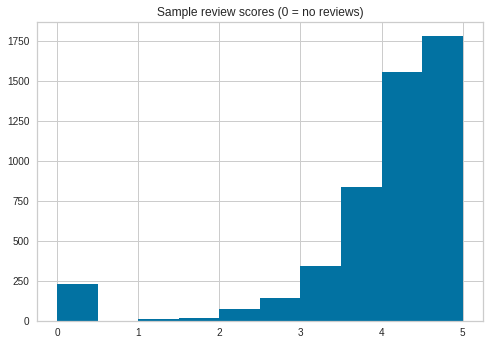

In [16]:
plt.hist(sample_X.prop_review_score)
plt.title('Sample review scores (0 = no reviews)');

##1.1 Dealing with NaNs in sample

In [17]:
print('Columns with missing data:\n', np.any(sample_X.isna(), axis=0))

Columns with missing data:
 srch_id                        False
site_id                        False
visitor_location_country_id    False
prop_country_id                False
prop_id                        False
prop_starrating                False
prop_review_score               True
prop_brand_bool                False
prop_location_score1           False
prop_location_score2            True
prop_log_historical_price      False
price_usd                      False
promotion_flag                 False
srch_destination_id            False
srch_length_of_stay            False
srch_booking_window            False
srch_adults_count              False
srch_children_count            False
srch_room_count                False
srch_saturday_night_bool       False
orig_destination_distance       True
random_bool                    False
comp2_rate                      True
comp2_inv                       True
comp3_rate                      True
comp3_inv                       True
comp5_rate

In [18]:
#How many entries for each column are NaN?

for c in sample_X.columns:
  print('NaNs in {0}: {1}'.format(c, sample_X[c].isna().sum()))

NaNs in srch_id: 0
NaNs in site_id: 0
NaNs in visitor_location_country_id: 0
NaNs in prop_country_id: 0
NaNs in prop_id: 0
NaNs in prop_starrating: 0
NaNs in prop_review_score: 9
NaNs in prop_brand_bool: 0
NaNs in prop_location_score1: 0
NaNs in prop_location_score2: 1080
NaNs in prop_log_historical_price: 0
NaNs in price_usd: 0
NaNs in promotion_flag: 0
NaNs in srch_destination_id: 0
NaNs in srch_length_of_stay: 0
NaNs in srch_booking_window: 0
NaNs in srch_adults_count: 0
NaNs in srch_children_count: 0
NaNs in srch_room_count: 0
NaNs in srch_saturday_night_bool: 0
NaNs in orig_destination_distance: 1631
NaNs in random_bool: 0
NaNs in comp2_rate: 3014
NaNs in comp2_inv: 2917
NaNs in comp3_rate: 3441
NaNs in comp3_inv: 3330
NaNs in comp5_rate: 2746
NaNs in comp5_inv: 2614
NaNs in comp8_rate: 3099
NaNs in comp8_inv: 3040


In [19]:
print('Sample size (with NaN entries):', sample_X.shape)
print('Sample size after dropping all NaN-possessing entries:', sample_X.dropna().shape)

Sample size (with NaN entries): (5000, 30)
Sample size after dropping all NaN-possessing entries: (449, 30)


If we were to drop all entries with NaNs we'd lose around 90% of sample data.

In [20]:
print('Means of comparison rates in sample data:', sample_X.comp2_rate.mean(), 
      sample_X.comp3_rate.mean(), sample_X.comp5_rate.mean(), 
      sample_X.comp8_rate.mean())

Means of comparison rates in sample data: 0.045317220543806644 0.01860166773572803 0.013309671694764862 -0.06891109942135717


In [21]:
print('Means of comparative availability in sample data:', sample_X.comp2_inv.mean(), 
      sample_X.comp3_inv.mean(), sample_X.comp5_inv.mean(), 
      sample_X.comp8_inv.mean())

Means of comparative availability in sample data: 0.03888622179548728 0.05389221556886228 0.054065381391450125 0.010714285714285714


The comparative rates and comparative availability all oscillate around 0, so we can fill in the missing data with 0s instead of dropping rows with NaNs in these columns.

In [22]:
fill_cols = ['comp2_rate', 'comp2_inv', 'comp3_rate', 'comp3_inv', 'comp5_rate', 'comp5_inv', 'comp8_rate', 'comp8_inv']
sample_X_imputed = pd.DataFrame.copy(sample_X)
sample_X_imputed[fill_cols] = sample_X_imputed[fill_cols].fillna(0)

Text(0.5, 1.0, 'Sample property review score')

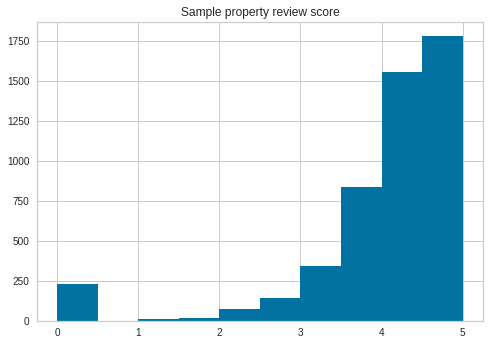

In [23]:
_, pr_bins, _ = plt.hist(sample_X_imputed.prop_review_score)
plt.title('Sample property review score')

Text(0.5, 1.0, 'Sample review scores with a genlogistic pdf fit')

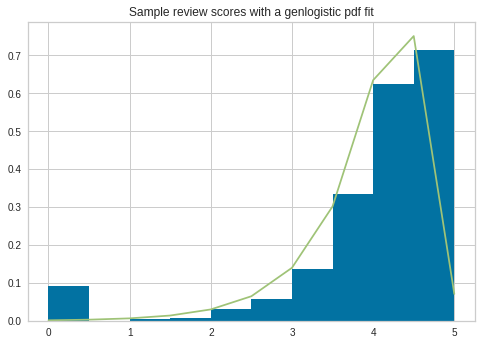

In [24]:
pr_params = sp.stats.genlogistic.fit(sample_X_imputed.prop_review_score[sample_X_imputed.prop_review_score > 0])
plt.hist(sample_X_imputed.prop_review_score, density=1)
pr_line = sp.stats.genlogistic.pdf(pr_bins, *pr_params)
plt.plot(pr_bins, pr_line)
plt.title('Sample review scores with a genlogistic pdf fit')

In [25]:
pr_filler_s = pd.Series(sp.stats.genlogistic.rvs(*pr_params, sample_X_imputed.prop_review_score.isna().sum()))
pr_filler_s.index = sample_X_imputed[sample_X_imputed.prop_review_score.isna()].index
sample_X_imputed.prop_review_score.fillna(pr_filler_s, inplace=True)
sample_X_imputed.prop_review_score.isna().any()

False

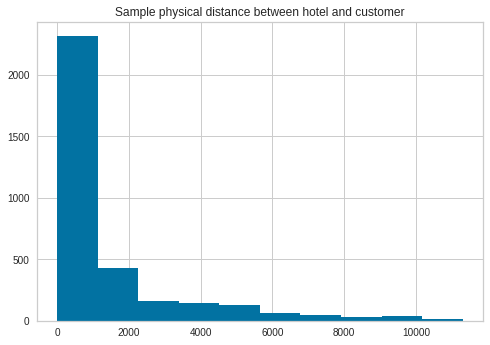

In [26]:
_, ddbins, _ = plt.hist(sample_X.orig_destination_distance)
plt.title('Sample physical distance between hotel and customer');

This appears to be an exponential distribution, so we fit an exponential.

Text(0.5, 1.0, 'Distance with fitted exponential distribution with parameters 0.05, 1357.38')

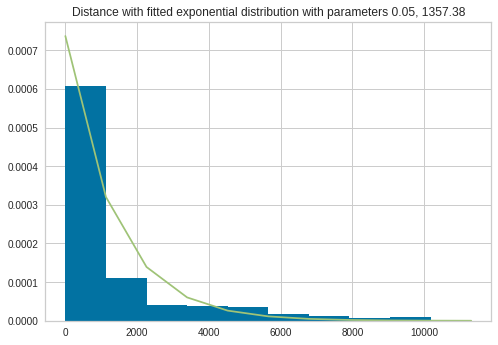

In [27]:
_, dd_bins, _ = plt.hist(sample_X.orig_destination_distance, density=1)
dd_params = sp.stats.expon.fit(sample_X.orig_destination_distance.dropna())
fit_dd_line = sp.stats.expon.pdf(dd_bins, *dd_params)
plt.plot(dd_bins, fit_dd_line)
plt.title('Distance with fitted exponential distribution with parameters {0}, {1}'.format(dd_params[0], round(dd_params[1], 2)))

Filling the distance from a fitted distribution might appear bizzare (since there is no reason why any specific property would be at any given distance from the customer), but we shall see whether this improves prediction accuracy.

In [28]:
dd_nan_count = sum(sample_X_imputed.orig_destination_distance.isna())
sample_X_imputed.orig_destination_distance = sample_X_imputed.orig_destination_distance.fillna(
    pd.Series(sp.stats.expon.rvs(*dd_params, dd_nan_count)))

Text(0.5, 1.0, 'Distance with fitted exponential distribution with parameters 0.0, 0.13')

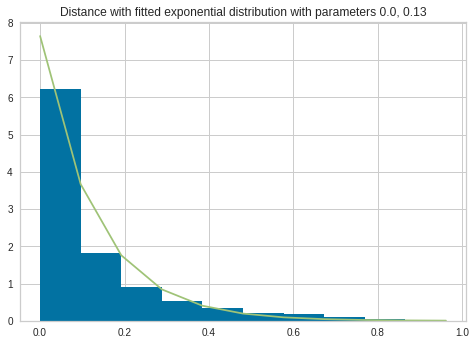

In [29]:
_, ls2_bins, _ = plt.hist(sample_X.prop_location_score2, density=1)
ls2_params = sp.stats.expon.fit(sample_X.prop_location_score2.dropna())
fit_ls2_line = sp.stats.expon.pdf(ls2_bins, *ls2_params)
plt.plot(ls2_bins, fit_ls2_line)
plt.title('Distance with fitted exponential distribution with parameters {0}, {1}'.format(ls2_params[0], round(ls2_params[1], 2)))

In [30]:
ls2_filler_s = pd.Series(sp.stats.expon.rvs(*ls2_params, sample_X_imputed.prop_location_score2.isna().sum()))
ls2_filler_s.index = sample_X_imputed[sample_X_imputed.prop_location_score2.isna()].index
sample_X_imputed.prop_location_score2.fillna(ls2_filler_s, inplace=True)
sample_X_imputed.prop_location_score2.isna().any()

False

Text(0.5, 1.0, 'Distance with fitted exponential distribution with parameters 0.05, 1357.38')

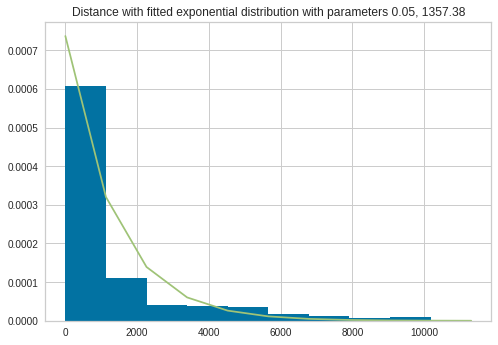

In [31]:
_, dd_bins, _ = plt.hist(sample_X.orig_destination_distance, density=1)
dd_params = sp.stats.expon.fit(sample_X.orig_destination_distance.dropna())
fit_dd_line = sp.stats.expon.pdf(dd_bins, *dd_params)
plt.plot(dd_bins, fit_dd_line)
plt.title('Distance with fitted exponential distribution with parameters {0}, {1}'.format(dd_params[0], round(dd_params[1], 2)))

In [32]:
dd_filler = sp.stats.expon.rvs(*dd_params, sample_X_imputed.orig_destination_distance.isna().sum())

In [33]:
dd_filler_s = pd.Series(dd_filler)
dd_filler_s.index = sample_X_imputed[sample_X_imputed.orig_destination_distance.isna()].index
sample_X_imputed.orig_destination_distance.fillna(dd_filler_s, inplace=True)

#3 Recommender

In [34]:
for c in train_data.columns:
  if train_data[c].isna().any():
    print('{0} has {1} ({2}%) of missing entries'.format(c, train_data[c].isna().sum(),
                                                         round(100 * train_data[c].isna().sum()/train_data.shape[0], 2)))

prop_review_score has 7364 (0.15%) of missing entries
prop_location_score2 has 1090348 (21.99%) of missing entries
orig_destination_distance has 1607782 (32.43%) of missing entries
comp2_rate has 2933675 (59.17%) of missing entries
comp2_inv has 2828078 (57.04%) of missing entries
comp3_rate has 3424059 (69.06%) of missing entries
comp3_inv has 3307357 (66.7%) of missing entries
comp5_rate has 2735974 (55.18%) of missing entries
comp5_inv has 2598327 (52.4%) of missing entries
comp8_rate has 3041693 (61.34%) of missing entries
comp8_inv has 2970844 (59.92%) of missing entries


##3.1 Imput missing data in train data

In [35]:
rs_params_train = sp.stats.genlogistic.fit(train_data.prop_review_score.dropna()[train_data.prop_review_score > 0])
ls2_params_train = sp.stats.expon.fit(train_data.prop_location_score2.dropna())
dd_params_train = sp.stats.expon.fit(train_data.orig_destination_distance.dropna())

rs_na_count_train = train_data.prop_review_score.isna().sum()
ls2_na_count_train = train_data.prop_location_score2.isna().sum()
dd_na_count_train = train_data.orig_destination_distance.isna().sum()

#generate values from fitted distribution
rs_fill_train = sp.stats.genlogistic.rvs(*rs_params_train, rs_na_count_train)
ls2_fill_train = sp.stats.expon.rvs(*ls2_params_train, ls2_na_count_train)
dd_fill_train = sp.stats.expon.rvs(*dd_params_train, dd_na_count_train)

In [36]:
rs_fill_series = pd.Series(rs_fill_train)
rs_fill_series.index = train_data.loc[train_data.prop_review_score.isna()].index

ls2_fill_series = pd.Series(ls2_fill_train, 
                            index=train_data.loc[train_data.prop_location_score2.isna()].index)

dd_fill_series = pd.Series(dd_fill_train, 
                           index=train_data.loc[train_data.orig_destination_distance.isna()].index)

In [37]:
train_data.prop_review_score.fillna(rs_fill_series, inplace=True)
train_data.prop_location_score2.fillna(ls2_fill_series, inplace=True)
train_data.orig_destination_distance.fillna(dd_fill_series, inplace=True)
for c in fill_cols:
  train_data[c].fillna(0, inplace=True)

In [38]:
train_data.isna().any()

srch_id                        False
site_id                        False
visitor_location_country_id    False
prop_country_id                False
prop_id                        False
prop_starrating                False
prop_review_score              False
prop_brand_bool                False
prop_location_score1           False
prop_location_score2           False
prop_log_historical_price      False
price_usd                      False
promotion_flag                 False
srch_destination_id            False
srch_length_of_stay            False
srch_booking_window            False
srch_adults_count              False
srch_children_count            False
srch_room_count                False
srch_saturday_night_bool       False
orig_destination_distance      False
random_bool                    False
comp2_rate                     False
comp2_inv                      False
comp3_rate                     False
comp3_inv                      False
comp5_rate                     False
c

##3.2 Extract target data and convert categorical entries to category

In [39]:
target_booking = train_data.pop('booking_bool') #used for training
target_click = train_data.pop('click_bool')

In [40]:
categorical_cols = ['srch_id', 'site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id',
       'srch_destination_id',
       'comp2_rate', 'comp2_inv', 'comp3_rate', 'comp3_inv', 'comp5_rate',
       'comp5_inv', 'comp8_rate', 'comp8_inv'] 

In [41]:
#for c in categorical_cols:
#  train_data[c] = train_data[c].astype('category')

#4 Modeling

##4.1 Try random forest for predicting

In [42]:
from sklearn.ensemble import RandomForestClassifier
import sklearn

In [43]:
forest = RandomForestClassifier()

In [44]:
sample_X_imputed.isna().any()

srch_id                        False
site_id                        False
visitor_location_country_id    False
prop_country_id                False
prop_id                        False
prop_starrating                False
prop_review_score              False
prop_brand_bool                False
prop_location_score1           False
prop_location_score2           False
prop_log_historical_price      False
price_usd                      False
promotion_flag                 False
srch_destination_id            False
srch_length_of_stay            False
srch_booking_window            False
srch_adults_count              False
srch_children_count            False
srch_room_count                False
srch_saturday_night_bool       False
orig_destination_distance      False
random_bool                    False
comp2_rate                     False
comp2_inv                      False
comp3_rate                     False
comp3_inv                      False
comp5_rate                     False
c

In [45]:
sample_X_train_booking, sample_X_test_booking, sample_y_train_booking, sample_y_test_booking = \
  sklearn.model_selection.train_test_split(sample_X_imputed, sample_y_booking)

In [46]:
sample_X_imputed

,srch_id,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,comp2_rate,comp2_inv,comp3_rate,comp3_inv,comp5_rate,comp5_inv,comp8_rate,comp8_inv
920872,61466,5,219,219,29163,3,4.0,1,2.30,0.053393,4.71,109.00,0,22077,3,1,2,2,1,0,4.260000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4627336,310442,5,219,219,22311,3,5.0,1,2.08,0.145200,4.87,107.00,0,18876,1,14,2,0,1,1,102.665361,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1578965,106043,5,23,215,95124,4,3.0,0,6.25,0.006271,5.40,251.00,0,2854,3,17,4,0,1,0,2252.290396,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
563179,37636,5,219,219,103663,3,4.0,0,4.13,0.017500,5.34,134.00,0,13216,2,0,1,0,1,1,12.210000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3766623,253025,5,219,219,31144,3,4.5,1,2.20,0.001800,5.17,152.00,0,18774,2,25,2,0,1,1,1742.370000,0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4191474,281244,5,219,219,52823,3,3.5,1,0.69,0.000300,4.96,108.00,0,1986,1,9,2,0,1,1,467.015514,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187545,12604,24,216,31,32307,0,3.5,0,6.74,0.109600,4.83,42.55,0,15620,2,3,1,0,1,1,404.203942,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2301123,154505,5,219,219,93758,3,4.5,0,3.09,0.053600,4.75,105.00,0,25017,1,1,2,0,1,0,140.130000,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1544805,103667,19,158,158,42669,3,3.5,0,2.40,0.076800,4.72,69.62,0,23525,3,6,2,0,1,1,1552.378719,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [47]:
forest.fit(sample_X_train_booking, sample_y_train_booking)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [48]:
forest.score(sample_X_test_booking, sample_y_test_booking)

0.9744

In [49]:
sklearn.model_selection.cross_val_score(forest, sample_X_imputed, sample_y_booking, cv=5)

array([0.971, 0.971, 0.971, 0.971, 0.97 ])

In [50]:
pred_sample_y_booking = forest.predict(sample_X_test_booking)

In [51]:
pred_prob_sample_y_booking = forest.predict_proba(sample_X_test_booking)

In [52]:
i = 0
for name, group in train_data.groupby('srch_id'):
  print(name)
  print(group)
  print(forest.predict(group))
  i += 1
  if i > 0:
    break

1
    srch_id  site_id  ...  comp8_rate  comp8_inv
0         1       12  ...         0.0        0.0
1         1       12  ...         0.0        0.0
2         1       12  ...         0.0        0.0
3         1       12  ...        -1.0        0.0
4         1       12  ...         0.0        0.0
5         1       12  ...         0.0        0.0
6         1       12  ...         0.0        0.0
7         1       12  ...         0.0        0.0
8         1       12  ...         0.0        0.0
9         1       12  ...         0.0        0.0
10        1       12  ...         0.0        0.0
11        1       12  ...         1.0        0.0
12        1       12  ...         0.0        0.0
13        1       12  ...         0.0        0.0
14        1       12  ...         0.0        0.0
15        1       12  ...         0.0        0.0
16        1       12  ...         0.0        0.0
17        1       12  ...         0.0        0.0
18        1       12  ...         0.0        0.0
19        1       

In [53]:
for p in pred_prob_sample_y_booking:
  print(p)

[0.95 0.05]
[0.93 0.07]
[0.9 0.1]
[0.97 0.03]
[1. 0.]
[0.97 0.03]
[0.9 0.1]
[0.98 0.02]
[1. 0.]
[0.89 0.11]
[0.98 0.02]
[0.97 0.03]
[0.99 0.01]
[0.97 0.03]
[0.97 0.03]
[1. 0.]
[0.93 0.07]
[1. 0.]
[0.96 0.04]
[0.99 0.01]
[0.99 0.01]
[0.97 0.03]
[0.96 0.04]
[0.98 0.02]
[0.89 0.11]
[0.99 0.01]
[0.94 0.06]
[0.93 0.07]
[0.99 0.01]
[0.97 0.03]
[0.99 0.01]
[0.98 0.02]
[0.98 0.02]
[0.96 0.04]
[0.99 0.01]
[0.9 0.1]
[0.99 0.01]
[0.98 0.02]
[1. 0.]
[0.98 0.02]
[0.98 0.02]
[0.97 0.03]
[0.98 0.02]
[0.99 0.01]
[0.95 0.05]
[0.88 0.12]
[0.97 0.03]
[0.97 0.03]
[0.9 0.1]
[0.97 0.03]
[0.99 0.01]
[0.97 0.03]
[0.92 0.08]
[0.98 0.02]
[0.96 0.04]
[0.96 0.04]
[0.99 0.01]
[1. 0.]
[1. 0.]
[0.8 0.2]
[0.96 0.04]
[0.94 0.06]
[0.98 0.02]
[0.99 0.01]
[0.99 0.01]
[0.92 0.08]
[0.98 0.02]
[0.95 0.05]
[0.92 0.08]
[0.94 0.06]
[0.93 0.07]
[0.97 0.03]
[1. 0.]
[0.96 0.04]
[0.97 0.03]
[0.94 0.06]
[0.97 0.03]
[0.96 0.04]
[0.97 0.03]
[0.99 0.01]
[0.98 0.02]
[0.99 0.01]
[0.96 0.04]
[0.97 0.03]
[0.93 0.07]
[0.98 0.02]
[0.98 0.02

In [54]:
print(sklearn.metrics.classification_report(sample_y_test_booking, pred_sample_y_booking))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1218
           1       0.00      0.00      0.00        32

    accuracy                           0.97      1250
   macro avg       0.49      0.50      0.49      1250
weighted avg       0.95      0.97      0.96      1250



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
print(sklearn.metrics.classification_report(sample_y_test_booking, [0]*sample_y_test_booking.size))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1218
           1       0.00      0.00      0.00        32

    accuracy                           0.97      1250
   macro avg       0.49      0.50      0.49      1250
weighted avg       0.95      0.97      0.96      1250



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
print(sklearn.metrics.classification_report(sample_y_test_booking, [1]*sample_y_test_booking.size))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1218
           1       0.03      1.00      0.05        32

    accuracy                           0.03      1250
   macro avg       0.01      0.50      0.02      1250
weighted avg       0.00      0.03      0.00      1250



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
print(sklearn.metrics.classification_report(sample_y_test_booking, np.random.randint(0, 2, size=sample_y_test_booking.size)))

              precision    recall  f1-score   support

           0       0.98      0.50      0.66      1218
           1       0.03      0.56      0.05        32

    accuracy                           0.50      1250
   macro avg       0.50      0.53      0.36      1250
weighted avg       0.95      0.50      0.65      1250



In [58]:
test_data

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff
0,1,24,216,NaN,NaN,219,3180,3,4.5,1,2.94,0.0691,5.03,119.00,0,19222,1,10,2,0,1,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,24,216,NaN,NaN,219,5543,3,4.5,1,2.64,0.0843,4.93,118.00,0,19222,1,10,2,0,1,0,NaN,NaN,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,24,216,NaN,NaN,219,14142,2,3.5,1,2.71,0.0556,4.16,49.00,0,19222,1,10,2,0,1,0,NaN,NaN,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,24,216,NaN,NaN,219,22393,3,4.5,1,2.40,0.0561,5.03,143.00,0,19222,1,10,2,0,1,0,NaN,NaN,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,24,216,NaN,NaN,219,24194,3,4.5,1,2.94,0.2090,4.72,79.00,0,19222,1,10,2,0,1,0,NaN,NaN,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4959178,332787,24,216,NaN,NaN,117,32019,4,3.5,0,2.48,0.0551,4.53,66.07,0,19246,2,7,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,1.0,0.0,22.0,1.0,0.0,127.0,-1.0,0.0,27.0,1.0,0.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4959179,332787,24,216,NaN,NaN,117,33959,4,3.0,1,2.20,0.3344,4.39,67.10,0,19246,2,7,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,16.0,1.0,0.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4959180,332787,24,216,NaN,NaN,117,35240,4,0.0,0,1.79,NaN,4.64,73.91,0,19246,2,7,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,1.0,0.0,55.0,0.0,0.0,NaN,0.0,0.0,16.0,0.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4959181,332787,24,216,NaN,NaN,117,94437,4,0.0,0,2.94,0.0928,4.64,66.07,0,19246,2,7,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,1.0,0.0,43.0,1.0,0.0,43.0,-1.0,0.0,12.0,-1.0,0.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


One possible approach - fill all the search data with the fields in the query for every entry in test data and select the ones that most likely meet the criteria with the random forest.

Filtering - desination id (if possible), then:
* remove the properties which don't have free spaces
* run fitter on the remaining ones
* prioritize properties with promotions
* if more results than expected are left, choose first n

In [59]:
test_data.prop_country_id.unique().size

167

In [60]:
df = pd.DataFrame.from_dict({'A':[1,2,3], 'B':[2,5,7], 'C':[10, 12, 18]})

##4.2 Remove NaNs in test data

In [61]:
test_data.isna().any()

srch_id                        False
site_id                        False
visitor_location_country_id    False
visitor_hist_starrating         True
visitor_hist_adr_usd            True
prop_country_id                False
prop_id                        False
prop_starrating                False
prop_review_score               True
prop_brand_bool                False
prop_location_score1           False
prop_location_score2            True
prop_log_historical_price      False
price_usd                      False
promotion_flag                 False
srch_destination_id            False
srch_length_of_stay            False
srch_booking_window            False
srch_adults_count              False
srch_children_count            False
srch_room_count                False
srch_saturday_night_bool       False
srch_query_affinity_score       True
orig_destination_distance       True
random_bool                    False
comp1_rate                      True
comp1_inv                       True
c

In [62]:
for c in nan_filter.keys()[nan_filter]:
  if c in test_data:
    print(c, test_data[c].isna().sum() / test_data.shape[0] > 0.75)

visitor_hist_starrating True
visitor_hist_adr_usd True
srch_query_affinity_score True
comp1_rate True
comp1_inv True
comp1_rate_percent_diff True
comp2_rate_percent_diff True
comp3_rate_percent_diff True
comp4_rate True
comp4_inv True
comp4_rate_percent_diff True
comp5_rate_percent_diff True
comp6_rate True
comp6_inv True
comp6_rate_percent_diff True
comp7_rate True
comp7_inv True
comp7_rate_percent_diff True
comp8_rate_percent_diff True


As it turns out, the same columns which would be removed from train_data are also remoed from test_data.

In [63]:
na_threshold = test_data.shape[0] * 0.75
test_data.isna().sum() > na_threshold

srch_id                        False
site_id                        False
visitor_location_country_id    False
visitor_hist_starrating         True
visitor_hist_adr_usd            True
prop_country_id                False
prop_id                        False
prop_starrating                False
prop_review_score              False
prop_brand_bool                False
prop_location_score1           False
prop_location_score2           False
prop_log_historical_price      False
price_usd                      False
promotion_flag                 False
srch_destination_id            False
srch_length_of_stay            False
srch_booking_window            False
srch_adults_count              False
srch_children_count            False
srch_room_count                False
srch_saturday_night_bool       False
srch_query_affinity_score       True
orig_destination_distance      False
random_bool                    False
comp1_rate                      True
comp1_inv                       True
c

In [64]:
for c in nan_filter.keys()[nan_filter]:
  if c in test_data:
    test_data.drop(columns=[c], inplace=True)

##4.3 Fill NaNs in test_data

Moving on, we can impute the data for the purposes of modeling.

In [65]:
print('Percent missing data in test_data:')
test_data.isna().sum()/test_data.shape[0]*100

Percent missing data in test_data:


srch_id                         0.000000
site_id                         0.000000
visitor_location_country_id     0.000000
prop_country_id                 0.000000
prop_id                         0.000000
prop_starrating                 0.000000
prop_review_score               0.146516
prop_brand_bool                 0.000000
prop_location_score1            0.000000
prop_location_score2           21.939743
prop_log_historical_price       0.000000
price_usd                       0.000000
promotion_flag                  0.000000
srch_destination_id             0.000000
srch_length_of_stay             0.000000
srch_booking_window             0.000000
srch_adults_count               0.000000
srch_children_count             0.000000
srch_room_count                 0.000000
srch_saturday_night_bool        0.000000
orig_destination_distance      32.438388
random_bool                     0.000000
comp2_rate                     59.348929
comp2_inv                      57.225434
comp3_rate      

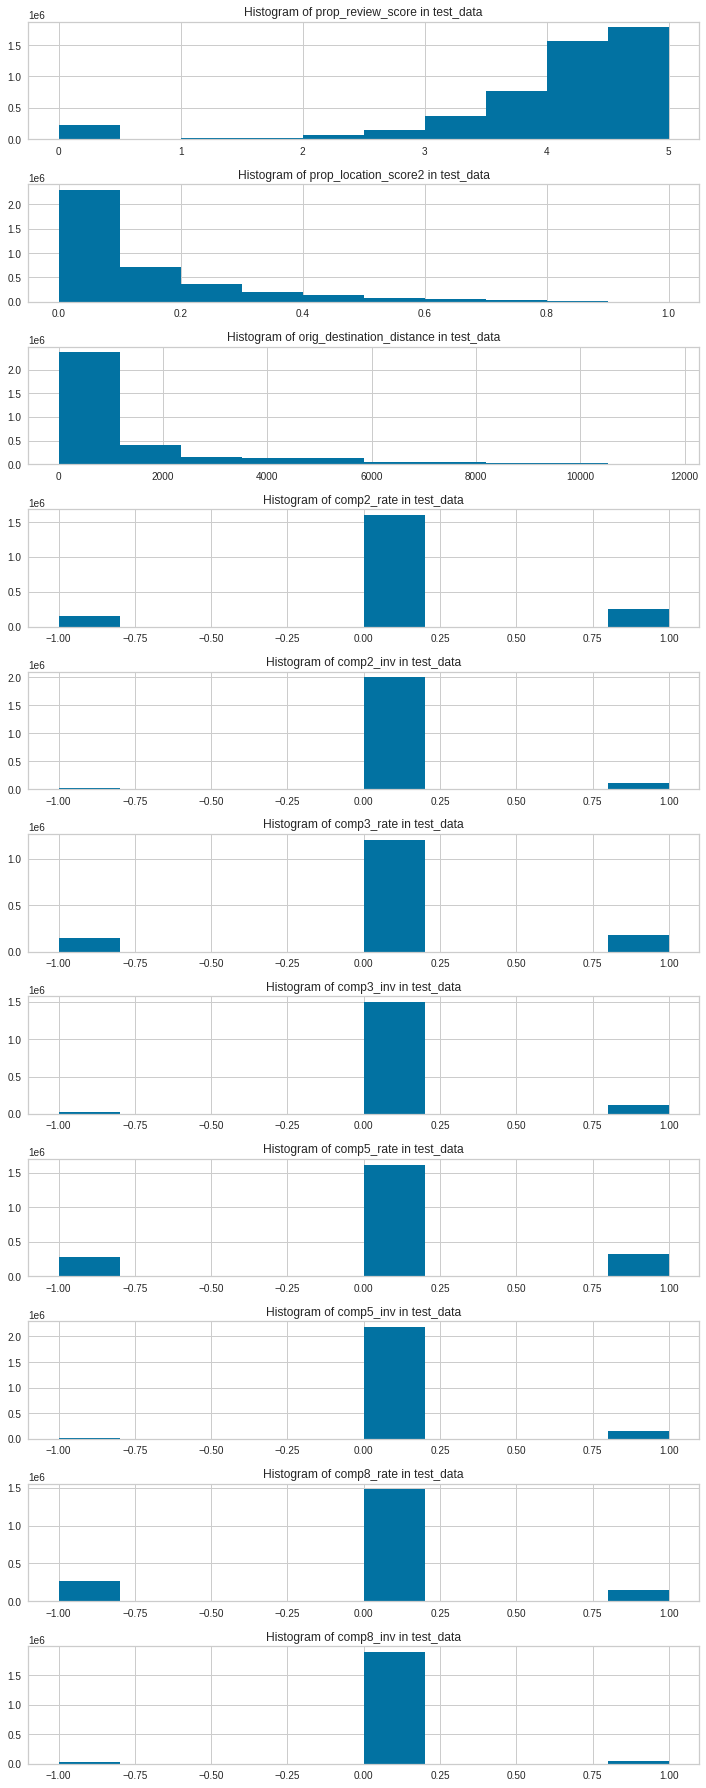

In [66]:
na_columns_test = test_data.isna().any()
plot_n = na_columns_test.sum()
fig, ax = plt.subplots(plot_n, figsize=(10, 25))
for i, c in enumerate(na_columns_test.keys()[na_columns_test]):
  ax[i].hist(test_data[c])
  ax[i].set_title('Histogram of {0} in test_data'.format(c))

plt.tight_layout()

Same pattern of data as in train_data, therefore we use the same techniques to fill in missing values.

In [67]:
rs_params_test = sp.stats.genlogistic.fit(test_data.prop_review_score.dropna()[test_data.prop_review_score > 0])
ls2_params_test = sp.stats.expon.fit(test_data.prop_location_score2.dropna())
dd_params_test = sp.stats.expon.fit(test_data.orig_destination_distance.dropna())

rs_na_count_test = test_data.prop_review_score.isna().sum()
ls2_na_count_test = test_data.prop_location_score2.isna().sum()
dd_na_count_test = test_data.orig_destination_distance.isna().sum()

#generate values from fitted distribution
rs_fill_test = sp.stats.genlogistic.rvs(*rs_params_test, rs_na_count_test)
ls2_fill_test = sp.stats.expon.rvs(*ls2_params_test, ls2_na_count_test)
dd_fill_test = sp.stats.expon.rvs(*dd_params_test, dd_na_count_test)

rs_fill_series_test = pd.Series(rs_fill_test, 
                           index=test_data.loc[test_data.prop_review_score.isna()].index)

ls2_fill_series_test = pd.Series(ls2_fill_test, 
                            index=test_data.loc[test_data.prop_location_score2.isna()].index)

dd_fill_series_test = pd.Series(dd_fill_test, 
                           index=test_data.loc[test_data.orig_destination_distance.isna()].index)

In [68]:
test_data.prop_review_score.fillna(rs_fill_series_test, inplace=True)
test_data.prop_location_score2.fillna(ls2_fill_series_test, inplace=True)
test_data.orig_destination_distance.fillna(dd_fill_series_test, inplace=True)
for c in fill_cols:
  test_data[c].fillna(0, inplace=True)

In [69]:
test_data.isna().any()

srch_id                        False
site_id                        False
visitor_location_country_id    False
prop_country_id                False
prop_id                        False
prop_starrating                False
prop_review_score              False
prop_brand_bool                False
prop_location_score1           False
prop_location_score2           False
prop_log_historical_price      False
price_usd                      False
promotion_flag                 False
srch_destination_id            False
srch_length_of_stay            False
srch_booking_window            False
srch_adults_count              False
srch_children_count            False
srch_room_count                False
srch_saturday_night_bool       False
orig_destination_distance      False
random_bool                    False
comp2_rate                     False
comp2_inv                      False
comp3_rate                     False
comp3_inv                      False
comp5_rate                     False
c

##4.4 Train random fores on complete train_data

In [70]:
forest_booking = RandomForestClassifier()
forest_booking.fit(train_data, target_booking)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [71]:
train_data.columns

Index(['srch_id', 'site_id', 'visitor_location_country_id', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'orig_destination_distance', 'random_bool',
       'comp2_rate', 'comp2_inv', 'comp3_rate', 'comp3_inv', 'comp5_rate',
       'comp5_inv', 'comp8_rate', 'comp8_inv'],
      dtype='object')

In [72]:
pred_prob_y_booking = forest_booking.predict_proba(test_data)

In [80]:
#get the amountt of predictions made for each group
group_sizes = [group.shape[0] for name, group in test_data.groupby('srch_id')]
  

In [133]:
prop_id_pred_booking = zip

[(1, 'a', 0), (2, 'b', 0), (3, 'c', 0)]

In [143]:
pred_booking_df = pd.DataFrame(pred_prob_sample_y_booking, columns=['no_booking', 'booking'])
pred_booking_df['srch_id'] = test_data.srch_id
pred_booking_df['prop_id'] = test_data.prop_id

sorted_prop_id_booking = []
for name, group in pred_booking_df.groupby('srch_id'):
  #for each search id, return the results of predictions, sorted by highest probability of booking
  sorted_prop_id_booking.append(group.sort_values('booking', ascending=False))

In [144]:
sorted_prop_id_booking[:2]

[    no_booking  booking  srch_id  prop_id
 24        0.89     0.11        1   123675
 9         0.89     0.11        1    54937
 2         0.90     0.10        1    14142
 6         0.90     0.10        1    34263
 27        0.93     0.07        1   134992
 16        0.93     0.07        1    74045
 1         0.93     0.07        1     5543
 26        0.94     0.06        1   128871
 0         0.95     0.05        1     3180
 22        0.96     0.04        1    95031
 18        0.96     0.04        1    82231
 13        0.97     0.03        1    63894
 21        0.97     0.03        1    94729
 14        0.97     0.03        1    72090
 11        0.97     0.03        1    61632
 5         0.97     0.03        1    28181
 3         0.97     0.03        1    22393
 10        0.98     0.02        1    56050
 7         0.98     0.02        1    37567
 23        0.98     0.02        1    99484
 12        0.99     0.01        1    61934
 19        0.99     0.01        1    89466
 20        